<p>This file aims to deepen the data analysis of the Uber dataset, focusing on the exploration of charts and relationships between variables in a visual manner. It will build upon the work done in Part 1, reusing functions and transformations to ensure efficiency and consistency in the analysis.</p>

<p>Part 3 is dedicated to learning linear regression. Using the Uber dataset from 2024, we will build and validate a regression model to forecast the monthly (or annual) number of Uber rides for 2025.</p>

Link to Part 1 File: [Uber Data Analysis - Part 1](https://www.kaggle.com/code/annecarolinepena/uber-dataset-part-1-exploratory-data-analysis)
<br />
Link to Part 2 File: [Uber Data Analysis - Part 2](https://www.kaggle.com/code/annecarolinepena/uber-dataset-part-2-exploratory-data-analysis)

In [1]:
# Setting up the environment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

print("Setup Complete")

warnings.filterwarnings("ignore") # ignore all warnings

Setup Complete


In [2]:
# Load the Dataset
filepath =  "../input/uber-dataset/ncr_ride_bookings_eda.csv"
uber_data = pd.read_csv(filepath)
uber_data.head(5)

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,...,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method,day_week,day_week_name,hour,Group of Reasons,Cancelled by
0,2024-03-23,2025-08-31 12:29:38,"""CNR5884300""",No Driver Found,"""CID1982111""",eBike,Palam Vihar,Jhilmil,0.0,0.0,...,0,0.00,0.0,0.0,NaN,5,Saturday,12,Unknown,NaN
1,2024-11-29,2025-08-31 18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,...,237,5.73,0.0,0.0,UPI,4,Friday,18,Unknown,NaN
2,2024-08-23,2025-08-31 08:56:10,"""CNR8494506""",Completed,"""CID9202816""",Auto,Khandsa,Malviya Nagar,13.4,25.8,...,627,13.58,4.9,4.9,Debit Card,4,Friday,8,Unknown,NaN
3,2024-10-21,2025-08-31 17:17:25,"""CNR8906825""",Completed,"""CID2610914""",Premier Sedan,Central Secretariat,Inderlok,13.1,28.5,...,416,34.02,4.6,5.0,UPI,0,Monday,17,Unknown,NaN
4,2024-09-16,2025-08-31 22:08:00,"""CNR1950162""",Completed,"""CID9933542""",Bike,Ghitorni Village,Khan Market,5.3,19.6,...,737,48.21,4.1,4.3,UPI,0,Monday,22,Unknown,NaN


<h1>What is Linear Regression?</h1>

<p>
Linear regression models the relationship between a target variable <strong>y</strong> and one or more predictors like  <strong>x1</strong>, <strong>x2</strong>, ...<strong>xn</strong> assuming a linear form. In our case, <strong>y</strong> could be the <strong>number of rides</strong> and the predictors could be <strong>prices</strong>, <strong>month</strong>, <strong>hour</strong>.  
</p>

<p>The purpose of linear regression can be: </p>
<ul>
    <li>explanatory: to understand effects</li>
    <li>predictive: to forecast future values</li>
</ul>
<p>The central assumption is that, after suitable transformations, the conditional mean of y, y can be expressed as a linear combination of predictors.</p>

<h3>Why this model is important?</h3>

<ul>
    <li>With this model is easy to explain the effect of each variable</li>
    <li>Used as baseline model for complex models</li>
    <li>Common used in forecasting, relationship estimation and policy effect estimation</li>
</ul>

<h3>Main Assumptions</h3>

<p>Classical Linear Regression (OLS) relies on several assumptions about the data and the errors. These assumptions ensure desirable properties of estimators and valid hypothesis testing and confidence intervals.</p>

<table>
  <tr>
    <th>Assumptions</th>
    <th>What it means</th>
    <th>How to spot troubles</th>
  </tr>
  <tr>
    <td>Linearity</td>
    <td>Relationship is roughly a straight line.</td>
    <td>Residuals vs fitted shows curved pattern.</td>       
  </tr>
  <tr>
    <td>Exogeneity</td>
    <td>No important omitted variable that affects both X and y.</td>
    <td>Coefficients change a lot when adding controls; suspicion of bias.</td>
  </tr>
  <tr>
    <td>Homoscedasticity</td>
    <td>Error "size" is about the same across X.</td>
    <td>Residual spread increases/decreases with fitted values (funnel).</td>
  </tr>
  <tr>
    <td>Independence of errors</td>
    <td>Errors not correlated across observations (important for time series).</td>
    <td>Residuals show temporal pattern (autocorrelation).</td>
  </tr>
</table>

<h3>Evaluation metrics</h3>

<p><strong>MAE (Mean Absolute Error)</strong> is the average of the absolute values of the errors. It gives the average "size" of the error (ignores sign). It is easy to interpret: "on average, I was off by X units." Prefer MAE when you want a more direct and robust measure, less affected by outliers, and easy to understand.</p>

<p><strong>RMSE (Root Mean Squared Error)</strong> is the square root of the mean of the squared errors. RMSE penalizes large errors more strongly (because of the squaring). Prefer RMSE when you want to heavily penalize large errors (for example, when large mistakes are especially costly) or when you optimize models that minimize squared error. </p>


In [3]:
from sklearn.linear_model import LinearRegression

In [4]:
# Groupping the number of rides per month
uber_data['Date'] = pd.to_datetime(uber_data['Date'], errors='coerce')
if uber_data['Date'].dt.day.nunique() > 1:
    uber_data = uber_data.groupby(uber_data['Date'].dt.to_period('M')).agg({'Booking ID':'count'}).reset_index()
    uber_data['Date'] = uber_data['Date'].dt.to_timestamp()
else:
    uber_data['Date'] = uber_data['Date'].dt.to_period('M').dt.to_timestamp()
print(uber_data)
uber_data = uber_data.sort_values('Date').reset_index(drop=True)

         Date  Booking ID
0  2024-01-01       12861
1  2024-02-01       11927
2  2024-03-01       12719
3  2024-04-01       12199
4  2024-05-01       12778
5  2024-06-01       12440
6  2024-07-01       12897
7  2024-08-01       12636
8  2024-09-01       12248
9  2024-10-01       12651
10 2024-11-01       12394
11 2024-12-01       12250


In [5]:
uber_data['index'] = np.arange(1, len(uber_data) + 1) # Create an index to help in the regression
n_forecast = 12 # Defining the period to be predict
last_index = uber_data['index'].iloc[-1]
future_index = np.arange(last_index + 1, last_index + 1 + n_forecast)
future_index # index create for the 2025 months

array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])

In [6]:
last_date = uber_data['Date'].iloc[-1]
future_dates = pd.date_range(start = last_date + pd.offsets.MonthBegin(1), periods=n_forecast, freq='MS')
future_dates

DatetimeIndex(['2025-01-01', '2025-02-01', '2025-03-01', '2025-04-01',
               '2025-05-01', '2025-06-01', '2025-07-01', '2025-08-01',
               '2025-09-01', '2025-10-01', '2025-11-01', '2025-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [7]:
X = uber_data[['index']].values # extract index values and convert to NumPy Array
y = uber_data['Booking ID'].values # extract Booking ID values and convert to NumPy Array

lr = LinearRegression()
lr.fit(X, y)
lin_pred = lr.predict(future_index.reshape(-1, 1))
lin_pred

array([12438.22727273, 12428.72377622, 12419.22027972, 12409.71678322,
       12400.21328671, 12390.70979021, 12381.20629371, 12371.7027972 ,
       12362.1993007 , 12352.6958042 , 12343.19230769, 12333.68881119])

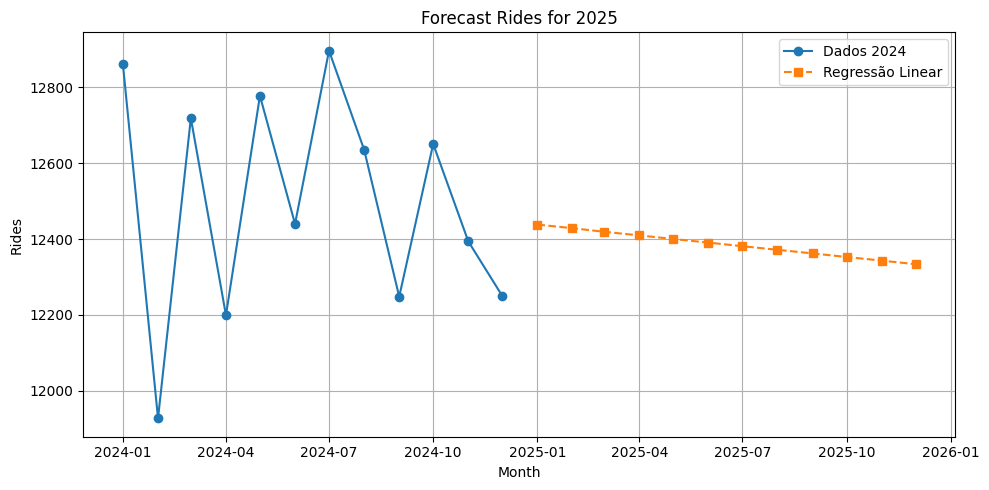

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(uber_data['Date'], uber_data['Booking ID'], 'o-', label='Dados 2024')  # Dados reais
plt.plot(future_dates, lin_pred, 's--', label='Regressão Linear')  

plt.xlabel('Month')
plt.ylabel('Rides')
plt.title('Forecast Rides for 2025')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig('uber_2025_forecasts.png')
plt.show()

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [10]:
y_true = uber_data['Booking ID'] 
y_pred = lin_pred

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

MAE: 265.7634, RMSE: 310.5631, R2: -0.1411


<p>As observed in the graph, the ride data for 2024 shows significant oscillations throughout the year, which may be influenced by factors such as economic changes, weather conditions, seasonal events, and other external factors. To predict the data for 2025, a very basic linear regression model was used, and it can be seen that the projections show a continuous decline in ride numbers throughout 2025. This happens because the regression model was based solely on historical ride data from 2024 and the indices of the months to be forecasted for 2025, without considering external variables that could significantly influence ride numbers.</p>
<p>In addition to observing the predictions, evaluation metrics for the model were calculated:</p>
<ul>
<li>MAE (Mean Absolute Error): 265.7634 — indicates that, on average, the predictions deviate from the actual values by approximately 266 rides. </li>
<li>RMSE (Root Mean Square Error): 310.5631 — shows a larger error when squared deviations are considered, highlighting the model's inability to capture significant variations in the data. </li>
<li>R² (Coefficient of Determination): -0.1411 — a negative result indicates that the model fails to explain the data's variability adequately, performing worse than a simple mean. </li>
</ul>
<p>These results confirm that the basic linear regression used is not effective in handling the oscillations seen in the 2024 data, nor in accurately predicting the 2025 data.</p>